In [1]:
from brian2 import * 
import matplotlib.pyplot as plt 
import numpy as np 

import sys 
sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from utils import *

In [2]:
def get_step_current(t_start, t_end,total_length, unit_time, amplitude, append_zero=True):


    assert isinstance(t_start, int), "t_start_ms must be of type int"
    assert isinstance(t_end, int), "t_end must be of type int"
    assert units.fundamentalunits.have_same_dimensions(amplitude, amp), \
        "amplitude must have the dimension of current e.g. brian2.uamp"
    tmp_size = total_length/unit_time  # +1 for t=0
    if append_zero:
        tmp_size += 1
    tmp = np.zeros((int(tmp_size), 1)) * amp
    tmp[int(t_start/unit_time): int(t_end/unit_time) + 1, 0] = amplitude
    curr = TimedArray(tmp, dt=1. * unit_time*ms)
    return curr

def OU_test(mu,dt,tau,sigma,unit,total_t):
    mu = mu
    dt = dt
    tau =tau
    sigma = sigma
    np.random.seed(0)
    time = np.arange(0,total_t,dt)
    x = np.zeros((len(time),1))
    x[0,0] =1

    for i in range(1,len(time)):
        # x[0,i] = x[0,i-1]+th*(mu-x[0,i-1])*dt+sig*sqrt(dt)*np.random.randn()
        x[i,0] = mu+((x[i-1,0]-mu)*np.exp(-dt/tau))+sigma*np.sqrt(1-np.exp(-2*dt/tau))*np.random.normal()
    # plt.plot(x[0])
    curr = TimedArray(x*unit, dt=dt*ms)
    return curr

def sim(ax_vm, parameters,input_current,plot=True):
    """
    simulate with parameters and plot to axes
    """

    # taken from Touboul_Brette_2008
    eqs = """
    i_stim = input_current(t,i):amp
    dvm/dt = (g_l*(e_l - vm) + g_l*d_t*exp((vm-v_t)/d_t) + i_stim - w)/c_m : volt
    dw/dt  = (a*(vm - e_l) - w)/tau_w : amp
    """

    neuron = NeuronGroup(
        1,
        model=eqs,
        threshold="vm > 0*mV",
        reset="vm = v_r; w += b",
        method="euler",
        namespace=parameters,
    )

    neuron.vm = parameters["e_l"]
    neuron.w = 0
    neuron.namespace["input_current"] = input_current

    states = StateMonitor(neuron, ["vm", "w"], record=True, when="thresholds")
    spikes = SpikeMonitor(neuron)
    defaultclock.dt = parameters['dt']
    run(parameters['runtime'] )

    # clip membrane voltages to threshold (0 mV)
    vms = np.clip(states[0].vm / mV, a_min=None, a_max=0)
    if plot:
        ax_vm.plot(states[0].t / ms, vms)
        ax_vm.scatter(int(spikes.t[:]/ms)*20,(states[0].t / ms)[int(spikes.t[:]/ms)*20])
        # ax_w.plot(states[0].t / ms, states[0].w / nA)
        # ax_vm_w.plot(vms, states[0].w / nA)

        # ax_w.sharex(ax_vm)
        # ax_vm.tick_params(labelbottom=False)

        ax_vm.set_ylabel("V [mV]")

        # ax_w.set_xlabel("t [ms]")
        # ax_w.set_ylabel("w [nA]")

        # ax_vm_w.set_xlabel("V [mV]")
        # ax_vm_w.set_ylabel("w [nA]")

        # ax_vm_w.yaxis.tick_right()
        # ax_vm_w.yaxis.set_label_position("right")
    return spikes.t[:]


In [89]:
def return_data_I(path):
    '''
    Loads the data from a single data file and returns input current

    args-
    path: path to the file
    '''
    dat = loadmatinpy(path)
    I = dat[0]['input_current']
    np.expand_dims(I,1)
    V = dat[0]['membrane_potential']
    unit_time = 1/20. * ms
    unit = pA
    tmp = np.expand_dims(I[:int(50000*20)]*5,1)*unit
    curr = TimedArray(tmp, dt=1. * unit_time)
    input_current = curr
    return input_current

In [45]:
I = return_data_I("D:/CurrentClamp/FN_analyzed/170704_NC_44_FN_analyzed.mat")

Text(0, 0.5, 'Firing rate(Hz)')

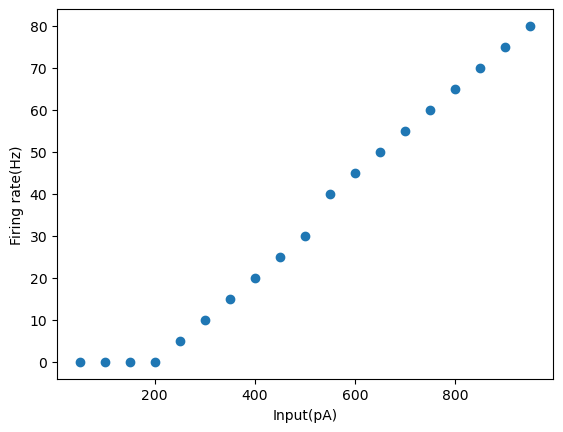

In [65]:
frs = []
for i in all_spikes:
    frs.append(len(i)/200)

plt.scatter(np.arange(50,1000,50),np.array(frs)*1000)
plt.xlabel('Input(pA)')
plt.ylabel('Firing rate(Hz)')

In [79]:
def get_STA(I,spikes):

    
    spk_ind = spikes
    # h = data_c1[0]['hidden_state']
    # spk_ind = data_c1[0]['spikeindices']
    sta = []

    TIME = 50*20
    for i in spk_ind:
        if i>TIME:
            sta.append(I[i-TIME:i,0])
    # plt.plot(np.arange(-50,0,1/20),np.array(sta)[:,:].T,c='grey',linewidth=0.2,alpha=0.3)
    plt.plot(np.arange(-50,0,1/20),np.mean(np.array(sta).T,axis=1),c='r',linewidth=4,alpha=0.5)

    plt.show()   


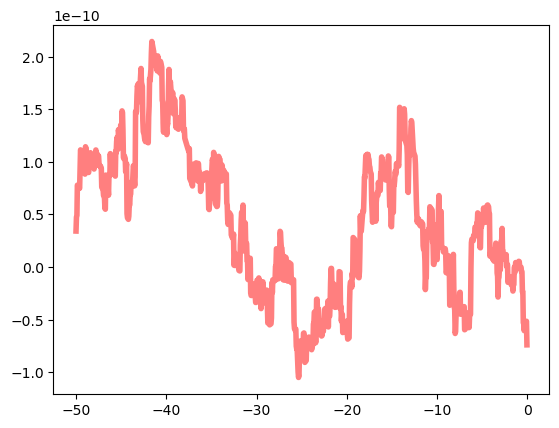

In [85]:
spks = np.array(spikes/ms*10,dtype=np.int32)
get_STA(I=I.values,spikes=spks)